# **Importing Libs**

In [2]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import sklearn
import tensorflow as tf
from tensorflow import keras
from PIL import Image as im
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout,MaxPooling2D,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn import preprocessing
import plotly.express as px
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

In [3]:
def contrast_enhancer(img):
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    image = clahe.apply(img) +20
    return image


def Blood_vessel_segmentation(img):
    image = cv2.Canny(img, 100, 200)
    return image


# **Paths**

In [4]:
#path to dataset
dataset_path = "/content/drive/MyDrive/data14"

# path for segmented_images
output_path = "/content/drive/MyDrive/EDGE14"

# To ensure the output directory exists, if not create
if not os.path.exists(output_path):
    os.makedirs(output_path)

train_root_path ='/content/drive/MyDrive/EDGE14/train'
test_root_path ='/content/drive/MyDrive/EDGE14/test'
validation_path='/content/drive/MyDrive/EDGE14/valid'

# **Prerocessing**

In [ ]:
# Function to preprocess images
def preprocess_image(image_path, output_folder):
    # Read the image
    image = cv2.imread(image_path)

    # Resize the image to 224x224
    image = cv2.resize(image, (224, 224))

    # Apply median blur
    image = cv2.medianBlur(image, 5)

    # grayscale conversion
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #CLAHE for contrast
    enchanced_image = contrast_enhancer(grayscale_image)

    #image segmentation using CannyEdge
    segmented_image = Blood_vessel_segmentation(enchanced_image)

    # Save the preprocessed image
    output_file = os.path.join(output_folder, os.path.basename(image_path))
    cv2.imwrite(output_file, l_clahe)


# Iterate through each class folder
for class_folder in os.listdir(dataset_path):
    class_folder_path = os.path.join(dataset_path, class_folder)

    # Create a corresponding output folder for preprocessed images
    output_class_folder = os.path.join(output_path, class_folder)
    if not os.path.exists(output_class_folder):
        os.makedirs(output_class_folder)

    # Process each image in the class folder
    for sub_folder in os.listdir(class_folder_path):
        sub_folders = os.path.join(class_folder_path, sub_folder)

        sub_class_folder = os.path.join(output_class_folder, sub_folder)
        if not os.path.exists(sub_class_folder):
            os.makedirs(sub_class_folder)

        for image_file in os.listdir(sub_folders):
          image_path = os.path.join(sub_folders, image_file)
          preprocess_image(image_path, sub_class_folder)

# **test_train_split**

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True,
rescale=1./255
)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [7]:
train_set = train_datagen.flow_from_directory(
    train_root_path,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 2076 images belonging to 2 classes.


In [8]:
validation_set = test_datagen.flow_from_directory(
    validation_path,
    target_size=(224,224),
    color_mode="rgb",
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 531 images belonging to 2 classes.


In [9]:
test_set = test_datagen.flow_from_directory(
    test_root_path,
    target_size=(224,224),
    color_mode="rgb",
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 231 images belonging to 2 classes.


In [10]:
#Check data type/shape
img= train_set[0]
print(f'data type: {type(train_set)}')
print(f'data shape: {train_set[0][0].shape}')
print(f'No of classes: {img[1].shape}')


data type: <class 'keras.src.preprocessing.image.DirectoryIterator'>
data shape: (32, 224, 224, 3)
No of classes: (32, 2)


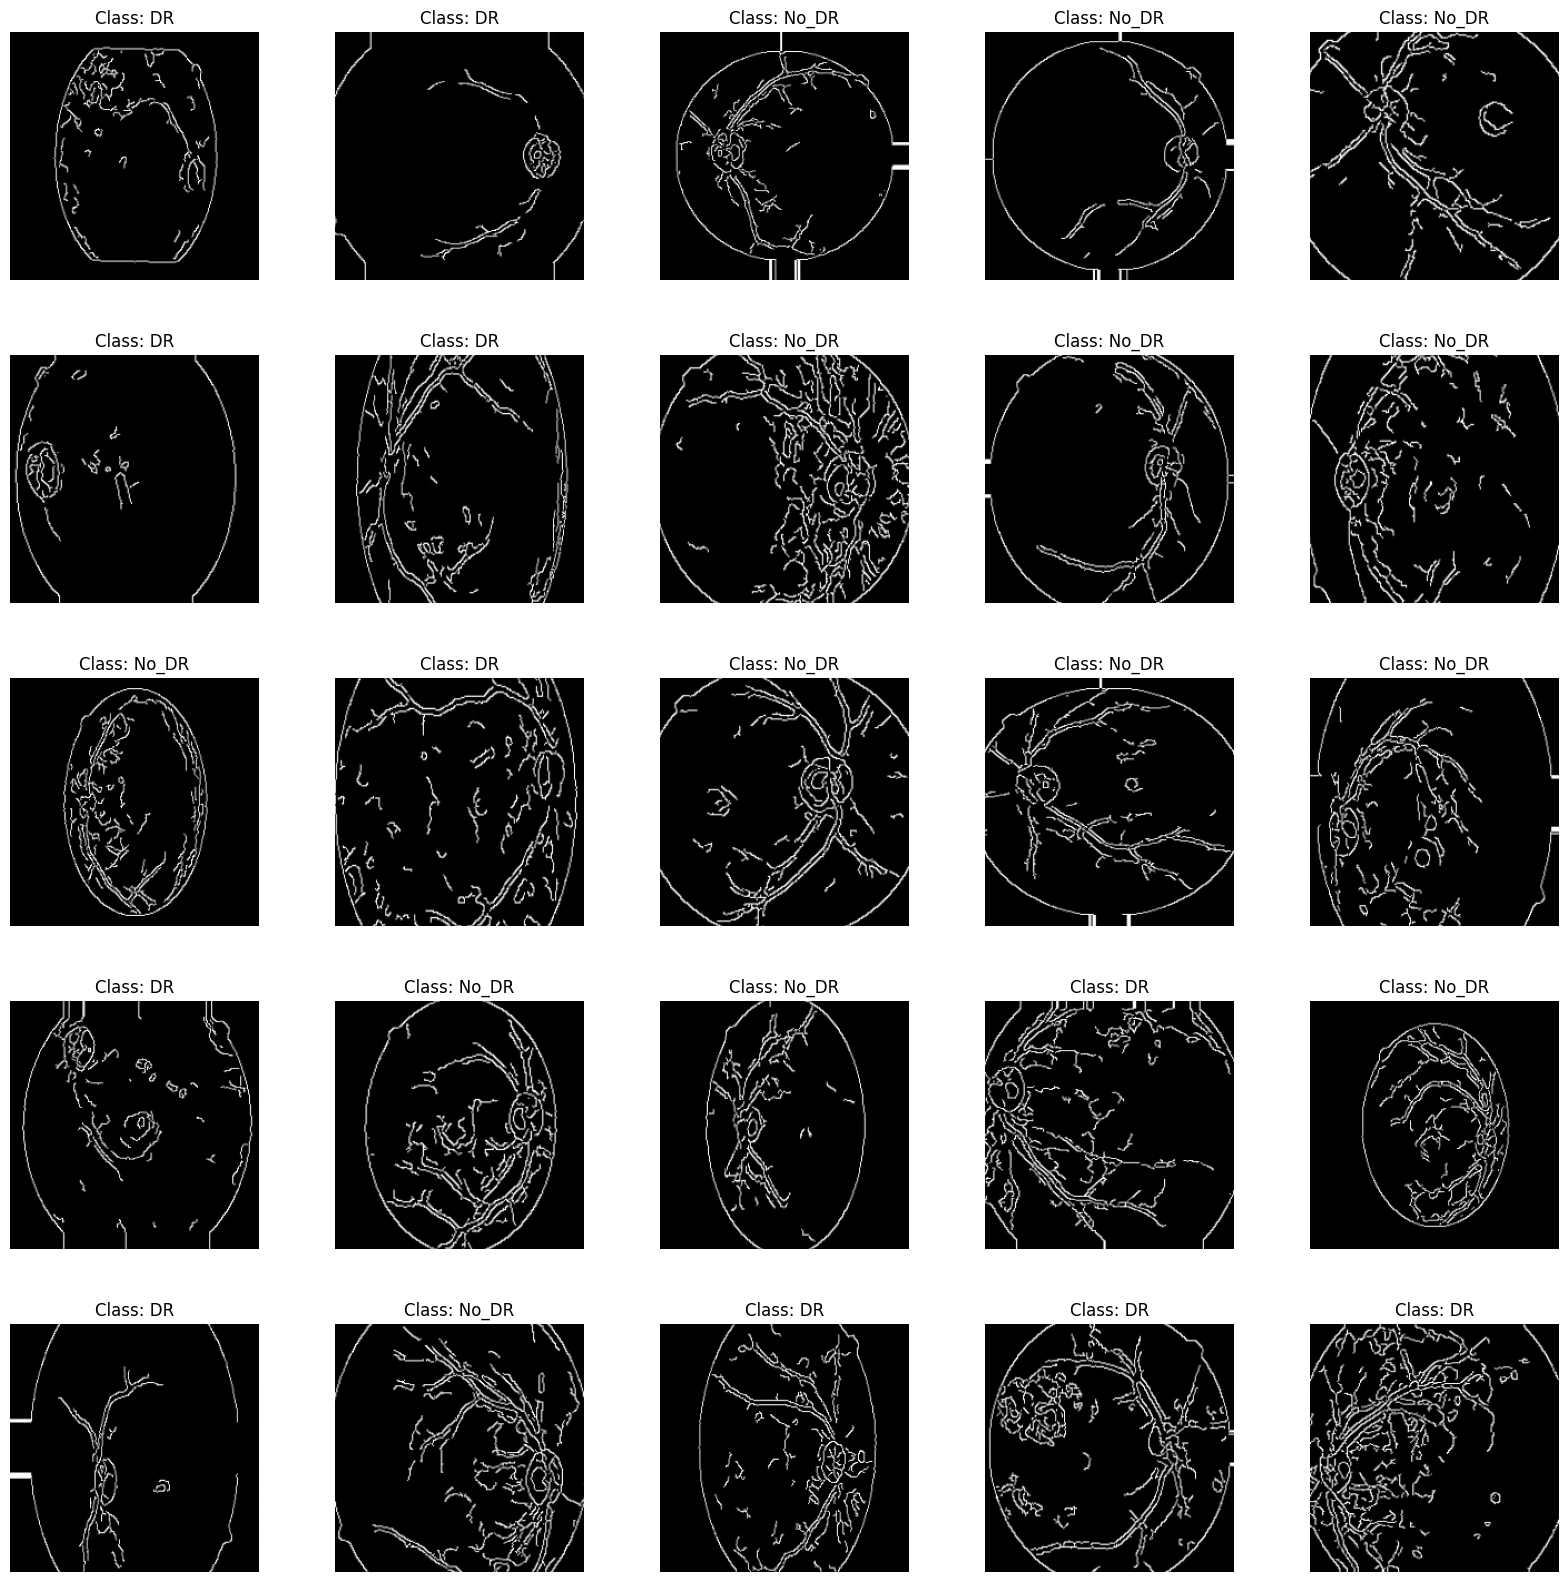

In [ ]:
#Grid of 25 sample training images with corresponding class labels.
labels = [k for k in train_set.class_indices]
sample_generate = train_set.__next__()

images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

for i in range(25):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[np.argmax(titles[i],axis=0)]}')
    plt.axis("off")

In [ ]:
#parameters
BATCH_SIZE = 32
IMAGE_SIZE = [224, 224]
CHANNELS=3
EPOCHS=25

In [ ]:
#creating an insctance of InceptionV3
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
# Layers in InceptionV3
for layer in inception.layers:
    print(layer)

In [ ]:
#fully connected Layer
model_inception = Sequential()

model_inception.add(inception)
model_inception.add(Flatten())
model_inception.add(Dropout(0.2))
model_inception.add(Dense(512,activation='relu'))
model_inception.add(Dropout(0.2))
model_inception.add(Dense(2,activation='softmax'))

In [ ]:
model_inception.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dropout (Dropout)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 512)               26214912  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 48018722 (183.18 MB)
Trainable params: 479

In [ ]:
#model_complie
model_inception.compile(
    optimizer = Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

In [ ]:
#Training
print("Training Started")
model_inception_history =model_inception.fit(
  train_set,
  validation_data=validation_set,
  epochs=EPOCHS,
  steps_per_epoch=len(train_set),
  validation_steps=len(test_set)
)

Epoch 1/25
65/65 [==============================] - 593s 8s/step - loss: 1.5468 - accuracy: 0.8473 - val_loss: 48392448.0000 - val_accuracy: 0.5508
Epoch 2/25
65/65 [==============================] - 120s 2s/step - loss: 0.9420 - accuracy: 0.8926 - val_loss: 3195.6497 - val_accuracy: 0.7500
Epoch 3/25
65/65 [==============================] - 80s 1s/step - loss: 0.2764 - accuracy: 0.9292 - val_loss: 18.2542 - val_accuracy: 0.9180
Epoch 4/25
65/65 [==============================] - 59s 906ms/step - loss: 0.2125 - accuracy: 0.9451 - val_loss: 0.1439 - val_accuracy: 0.9570
Epoch 5/25
65/65 [==============================] - 46s 701ms/step - loss: 0.1481 - accuracy: 0.9586 - val_loss: 0.1349 - val_accuracy: 0.9570
Epoch 6/25
65/65 [==============================] - 41s 632ms/step - loss: 0.1745 - accuracy: 0.9542 - val_loss: 0.2084 - val_accuracy: 0.9336
Epoch 7/25
65/65 [==============================] - 40s 617ms/step - loss: 0.1173 - accuracy: 0.9672 - val_loss: 0.1429 - val_accuracy: 0.

In [ ]:
#Save the model in the Path
model_inception.save("/content/drive/MyDrive/V3_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


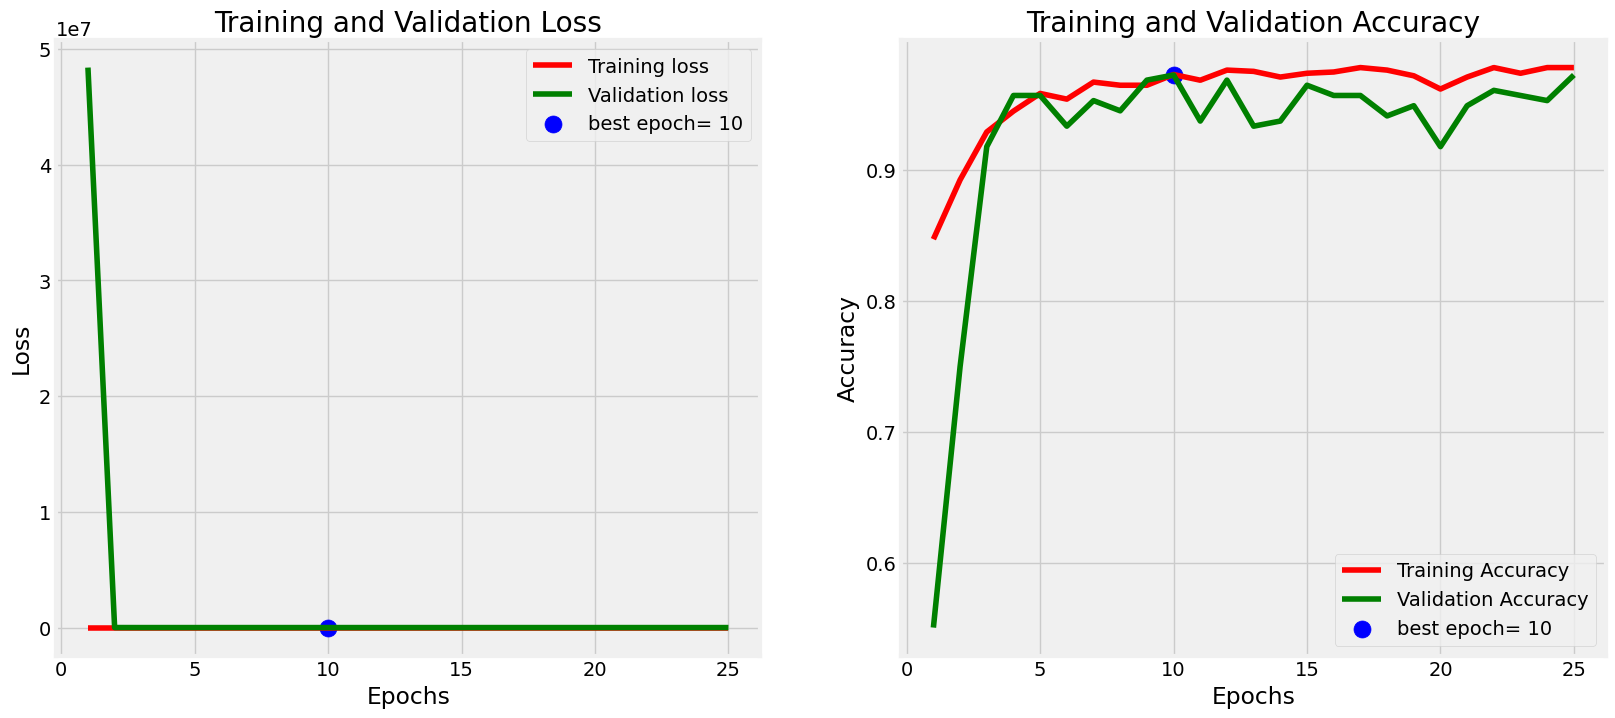

In [ ]:
# Define needed variables
tr_acc = model_inception_history.history['accuracy']
tr_loss = model_inception_history.history['loss']
val_acc = model_inception_history.history['val_accuracy']
val_loss = model_inception_history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Evaluate the model on the test set
loss = model_inception.evaluate(test_set)
print("Test Loss:", loss[0])
print("Test Accuracy:", loss[1])

# Get predictions on the test set
y_pred = model_inception.predict(test_set)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = test_set.classes

# Compute additional evaluation metrics
report = classification_report(y_true, y_pred_classes, target_names=test_set.class_indices)
print("Classification Report:")
print(report)

8/8 [==============================] - 91s 13s/step - loss: 0.0894 - accuracy: 0.9740
Test Loss: 0.08935044705867767
Test Accuracy: 0.9740259647369385
8/8 [==============================] - 2s 123ms/step
Classification Report:
              precision    recall  f1-score   support

          DR       0.47      0.47      0.47       113
       No_DR       0.49      0.49      0.49       118

    accuracy                           0.48       231
   macro avg       0.48      0.48      0.48       231
weighted avg       0.48      0.48      0.48       231

